## Attention Mechanism

This notebook is for understanding basic working of attention mechanism. 

For more detail see: [d2l.ai: Attention Mechanism](https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html).


In [2]:
import math
import torch
from torch import nn
import numpy as np

#### Basic Dot product

In [3]:
# 2-D arrays 
a = [[2, 1], [0, 3]]
b = [[1, 1], [3, 2]]

In [4]:
# using numpy
print(np.dot(b, a))

[[2 4]
 [6 9]]


#### Masked Softmax Operation

In decoder to hide the irrelevant future token we will use masking and for that we sets the attention weights to ${-\infty}$ or a large negative number, such as ${10}^{-6}$ in order to make their contribution to gradients and values vanish in practice. 

In [9]:
def masked_softmax(X, valid_lens): 
    """Perform softmax operation by masking elements on the last axis.
        X: 3D tensor
        valid_lens: 1D or 2D tensor
    """
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # replace masked value with larger negative number
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([10, 3]))

tensor([[[0.2198, 0.1493, 0.3208, 0.3101],
         [0.2641, 0.2647, 0.3257, 0.1456]],

        [[0.3749, 0.3579, 0.2672, 0.0000],
         [0.3174, 0.3348, 0.3478, 0.0000]]])

In [33]:
# with -inf
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei[0]

tensor([[ 5.5435,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-1.9945, -2.3841,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-2.7988,  6.1758, -0.5152,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.2541,  4.2728,  5.1140,  2.6404,    -inf,    -inf,    -inf,    -inf],
        [-3.3069,  4.1959, -0.6251,  1.0532,  9.6227,    -inf,    -inf,    -inf],
        [-0.9322,  5.9977, -3.3811, -4.1619, -2.0562, -2.1841,    -inf,    -inf],
        [ 0.0433,  7.0470,  7.0112,  5.1304,  5.2648,  6.4876,  0.8544,    -inf],
        [ 5.1793, -1.9175, -0.7140,  1.9007,  3.6249,  1.4243, -0.3554, -2.6618]])

In [34]:
# apply Softmax
wei = F.softmax(wei, dim=-1)
wei[0]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [5.9619e-01, 4.0381e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.2642e-04, 9.9863e-01, 1.2404e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.0675e-03, 2.8367e-01, 6.5782e-01, 5.5444e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4140e-06, 4.3768e-03, 3.5272e-05, 1.8893e-04, 9.9540e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.7646e-04, 9.9830e-01, 8.4359e-05, 3.8637e-05, 3.1733e-04, 2.7922e-04,
         0.0000e+00, 0.0000e+00],
        [3.1824e-04, 3.5029e-01, 3.3799e-01, 5.1530e-02, 5.8941e-02, 2.0021e-01,
         7.1617e-04, 0.0000e+00],
        [7.8106e-01, 6.4647e-04, 2.1539e-03, 2.9429e-02, 1.6505e-01, 1.8277e-02,
         3.0830e-03, 3.0713e-04]])

#### Matrix Multiplication

In [46]:
a = torch.randint(0, 4,(2,3))
b = torch.randint(0, 6,(3,2))
c = a @ b

print(f"{a=}")
print(f"{b=}") 
print() 
print(f"{c=}")

a=tensor([[3, 3, 0],
        [3, 0, 0]])
b=tensor([[4, 5],
        [0, 2],
        [4, 5]])

c=tensor([[12, 21],
        [12, 15]])


#### Self attention with scaled dot product

- Shape of queries: (batch_size, n_queries, dim) (here n: number of)
- Shape of keys: (batch_size, n_key-value, d)
- Shape of values: (batch_size, n_key-value, value_dim)
- Shape of valid_lens: (batch_size,) or (batch_size, n_queries)

In [76]:
class Attention(nn.Module): 
    """Basic scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [77]:
def check_shape(a, shape):
    assert a.shape == shape, f'tensor\'s shape {a.shape} != expected shape {shape}'

In [78]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = Attention(dropout=0.5)
attention.eval()

Attention(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [79]:
check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

In [74]:
import seaborn as sns

In [85]:
attention.attention_weights.shape 

torch.Size([2, 1, 10])

In [86]:
attention.attention_weights

tensor([[[0.3719, 0.6281, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1047, 0.1919, 0.1425, 0.2376, 0.1619, 0.1615, 0.0000, 0.0000,
          0.0000, 0.0000]]])

In [89]:
attention.attention_weights.reshape(2, -1) # 2d

tensor([[0.3719, 0.6281, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1047, 0.1919, 0.1425, 0.2376, 0.1619, 0.1615, 0.0000, 0.0000, 0.0000,
         0.0000]])

<Axes: >

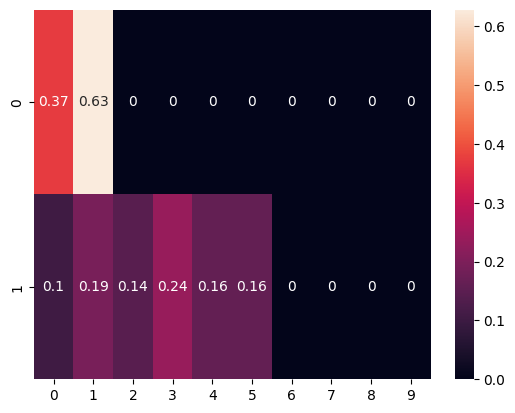

In [91]:
# plot heatmap
sns.heatmap(attention.attention_weights.reshape(2, -1), annot=True)

#### Multihead Attention

In [54]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = Attention(dropout)
        # As we want to initialize weights later on therefore 
        # use Lazy version to initialized the weights based on 
        # shape of queries and key-val pairs after first forward call
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # After transposing, shape of output:
        # (batch_size * num_heads, n_queries or n_key-value, num_hiddens / num_heads)
        
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, n_queries, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        
        # Shape of output_concat: (batch_size, n_queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [55]:
num_hiddens, num_heads = 100, 8
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
# init batch_size, n_q, n_kv
batch_size, num_queries, num_kvpairs = 12, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))

/Users/krinaljoshi/.local/share/virtualenvs/nlp-projects-KSis0_H_/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [61]:
X.shape

torch.Size([12, 4, 100])

In [62]:
Y.shape

torch.Size([12, 6, 100])

In [97]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [98]:
encoding_dim, num_steps = 32, 100
pos = PositionalEncoding(encoding_dim, 0.5)
X = pos(torch.zeros((1, num_steps, encoding_dim)))
P = pos.P[:, :X.shape[1], :]

In [99]:
X.shape

torch.Size([1, 100, 32])

In [100]:
P.shape

torch.Size([1, 100, 32])